In [17]:
import warnings
warnings.filterwarnings('ignore')

import numpy
import pandas
import iris
import iris.iterate
import iris.pandas
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import xarray as xr

In [11]:
%matplotlib inline

In [12]:
tfile = '/g/data/ua6/DRSv2/CMIP5/CCSM4/historical/mon/ocean/r1i1p1/thetao/latest/thetao_Omon_CCSM4_historical_r1i1p1_200001-200512.nc'
sfile = '/g/data/ua6/DRSv2/CMIP5/CCSM4/historical/mon/ocean/r1i1p1/so/latest/so_Omon_CCSM4_historical_r1i1p1_200001-200512.nc'
vfile = '/g/data/r87/dbi599/DRSv2/CMIP5/CCSM4/historical/fx/ocean/r0i0p0/volcello/latest/volcello-inferred_fx_CCSM4_historical_r0i0p0.nc'
bfile = '/g/data/r87/dbi599/DRSv2/CMIP5/CCSM4/historical/fx/ocean/r0i0p0/basin/latest/basin_fx_CCSM4_historical_r0i0p0.nc'

In [13]:
tcube = iris.load_cube(tfile)
scube = iris.load_cube(sfile)
vcube = iris.load_cube(vfile)
bcube = iris.load_cube(bfile)

/g/data/r87/dbi599/miniconda3/envs/ocean/lib/python3.6/site-packages/iris/fileformats/cf.py:798: UserWarning: Missing CF-netCDF measure variable 'areacello', referenced by netCDF variable 'thetao'
  warnings.warn(message % (variable_name, nc_var_name))
/g/data/r87/dbi599/miniconda3/envs/ocean/lib/python3.6/site-packages/iris/fileformats/cf.py:798: UserWarning: Missing CF-netCDF measure variable 'volcello', referenced by netCDF variable 'thetao'
  warnings.warn(message % (variable_name, nc_var_name))
/g/data/r87/dbi599/miniconda3/envs/ocean/lib/python3.6/site-packages/iris/fileformats/cf.py:798: UserWarning: Missing CF-netCDF measure variable 'areacello', referenced by netCDF variable 'so'
  warnings.warn(message % (variable_name, nc_var_name))
/g/data/r87/dbi599/miniconda3/envs/ocean/lib/python3.6/site-packages/iris/fileformats/cf.py:798: UserWarning: Missing CF-netCDF measure variable 'volcello', referenced by netCDF variable 'so'
  warnings.warn(message % (variable_name, nc_var_name)

In [14]:
tcube = tcube.collapsed('time', iris.analysis.MEAN)
scube = scube.collapsed('time', iris.analysis.MEAN)

In [15]:
tcube.data = tcube.data - 273.15
scube.data = scube.data * 1000

In [39]:
xdata = scube.data.flatten()
ydata = tcube.data.flatten()
vdata = vcube.data.flatten()
bdata = bcube.data.flatten()

## plt.hexbin

One approach is to use [plt.hexbin](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hexbin.html).

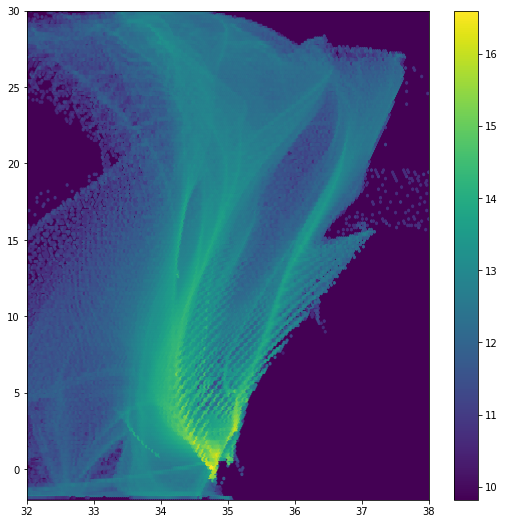

In [9]:
fig = plt.figure(figsize=[9, 9])

ax = fig.add_subplot(111, facecolor=cm.viridis(0))

plt.hexbin(xdata, ydata, C=vdata, reduce_C_function=numpy.sum,
           gridsize=200, bins='log', extent=(32, 38, -2, 30))  #mincnt=16
#plt.axis([xmin, xmax, ymin, ymax])
#plt.title("With a log color scale")
cb = plt.colorbar()  # extend='min'
plt.ylim(-2, 30)
plt.xlim(32, 38)
#cb.set_label('log10(N)')
plt.show()

In order to create a difference plot, it's possible to get the values from a `h=hexbin()` using `h.get_values()` and set the values using `h.set_values()`. Check out [this example](https://stackoverflow.com/questions/34255328/how-to-create-a-difference-map-between-two-matplotlib-hexbin-maps) for details.

Alteratively, I could run [scipy.stats.binned_statistic_2d](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binned_statistic_2d.html), which might be useful to get square bins. I'd then have to use a heat mapping package to create the plot.

## pandas.DataFrame.plot.hexbin

In pandas you can use [pandas.DataFrame.plot.hexbin](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.hexbin.html) instead.

In [7]:
basin_names = {0: 'land', 1: 'southern ocean', 2: 'atlantic', 
               3: 'pacific', 4: 'arctic', 5: 'indian', 
               6: 'mediterranean', 7: 'black sea', 8: 'hudson bay',
               9: 'baltic sea', 10: 'red sea'}

Looping isn't efficient, because the CCSM4 model, for example, is a 60 by 384 by 320 grid (>7,000,000 points).

In [9]:
#coord_names = [coord.name() for coord in tcube.dim_coords]
#data_list = []
#for tslice, sslice, vslice, bslice in iris.iterate.izip(tcube, scube, vcube, bcube):
#    if not type(tslice.data) == numpy.ma.core.MaskedArray:
#        slice_dict = {}
#        slice_dict['temperature'] = tslice.data
#        slice_dict['salinity'] = sslice.data
#        slice_dict['latitude'] = tslice.coord('latitude').points[0]
#        slice_dict['longitude'] = tslice.coord('longitude').points[0]
#        slice_dict['depth'] = tslice.coord('depth').points[0]
#        slice_dict['volume'] = vslice.data
#        slice_dict['basin'] = basin_names[bslice.data.item()]
#        data_list.append(slice_dict)
        
#data_df = pandas.DataFrame(data_list) 
#data_df.to_csv('/g/data/r87/dbi599/temp/ts_CCSM4.csv')

In [42]:
df = pandas.DataFrame(index=range(xdata.shape[0]))
df['temperature'] = ydata.filled(fill_value=5000)
df['salinity'] = xdata.filled(fill_value=5000)
df['volume'] = vdata.filled(fill_value=5000)

In [47]:
df = df[df.temperature != 5000]

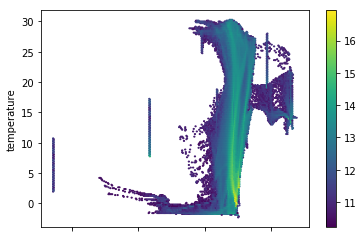

In [48]:
ax = df.plot.hexbin(x='salinity',
                    y='temperature',
                    C='volume',
                    reduce_C_function=numpy.sum,
                    gridsize=200,
                    bins='log',
                    cmap="viridis")

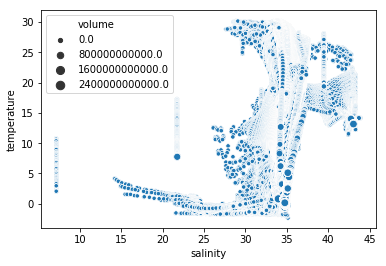

In [49]:
ax = sns.scatterplot(x="salinity",
                     y="temperature", 
                     size="volume",
                     data=df)
#hue="basin",

In [ ]:
sns.relplot(x="salinity",
            y="temperature",
            hue="basin",
            size="volume",
            sizes=(40, 400),
            alpha=.5,
            palette="muted",
            height=6,
            data=data_df)